# Pebl Image Processing: "QR" Approach

In [447]:
import numpy as np
import matplotlib.pyplot as plt

In [448]:
def render_image(image):
    plt.figure(figsize=(12, 10), dpi=150)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

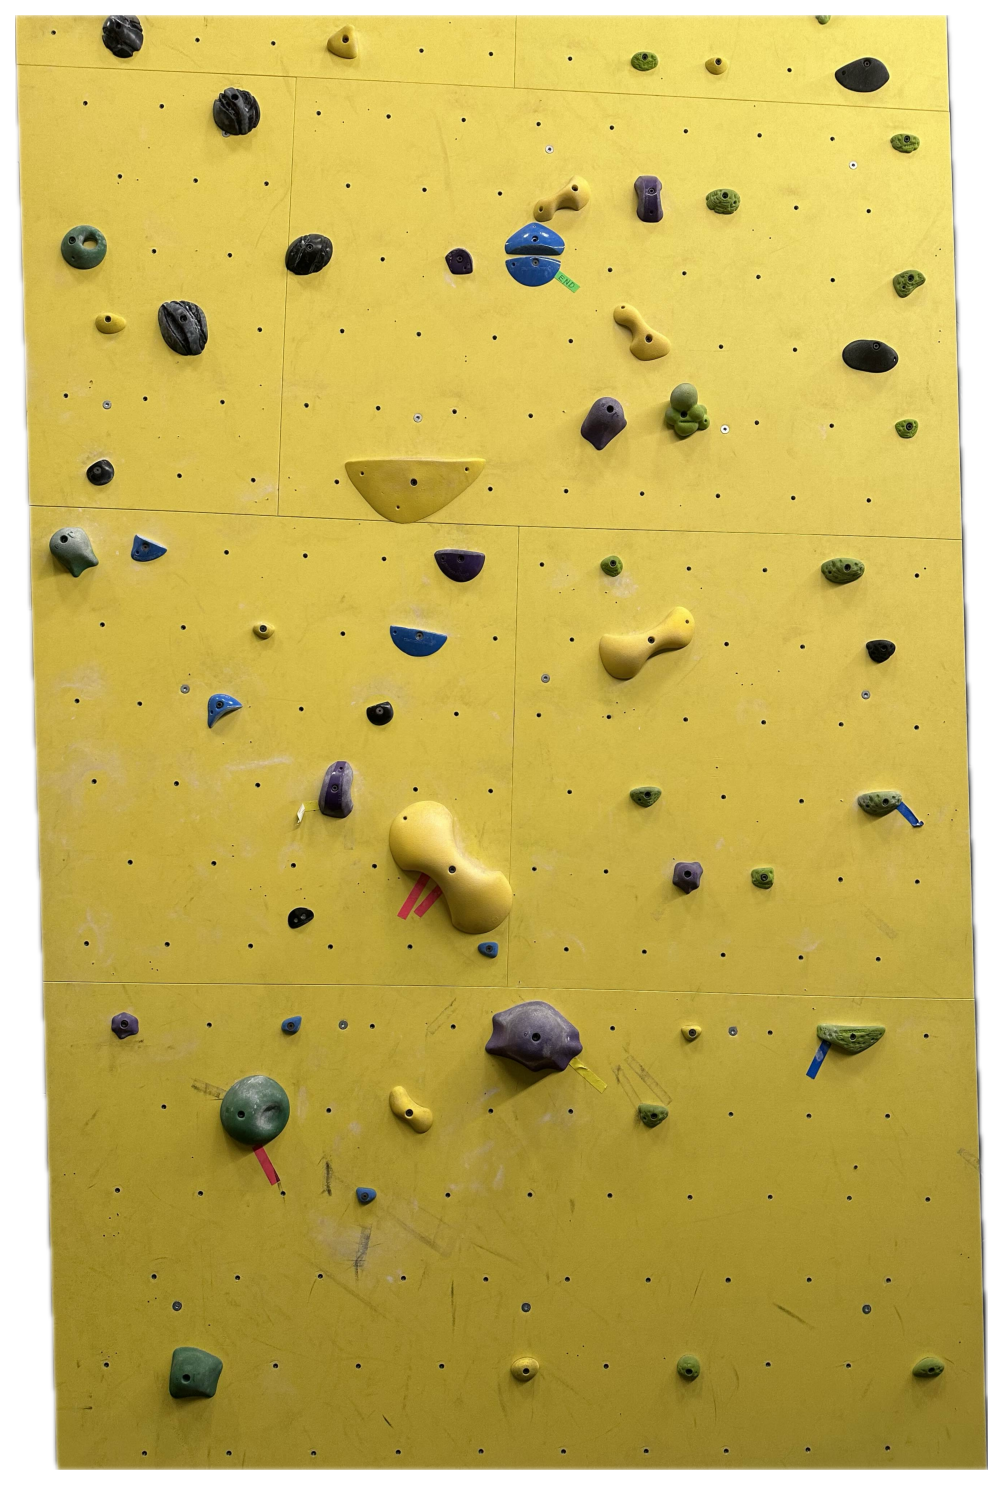

In [449]:
# Display the picture (no edits)
f = plt.imread('images/masked_close_up.png')
render_image(f)

# Smooth

In [450]:
def smooth_image(image, kernel_size=64):
    """
    Process image by dividing it into kernel_size x kernel_size sections
    and applying the average color to each section.
    
    Args:
        image: Input image array (height x width x channels)
        kernel_size: Size of each square section (default: 64)
    
    Returns:
        Processed image with averaged sections
    """
    height, width = image.shape[:2]
    result = image.copy()
    
    # Process each kernel_size x kernel_size section
    for i in range(0, height, kernel_size):
        for j in range(0, width, kernel_size):
            # Define the boundaries of the current section
            i_end = min(i + kernel_size, height)
            j_end = min(j + kernel_size, width)
            
            # Extract the section
            section = image[i:i_end, j:j_end]
            
            # Calculate the average color for this section
            avg_color = section.mean(axis=(0, 1))
            
            # Apply the average color to the entire section
            result[i:i_end, j:j_end] = avg_color
    
    return result

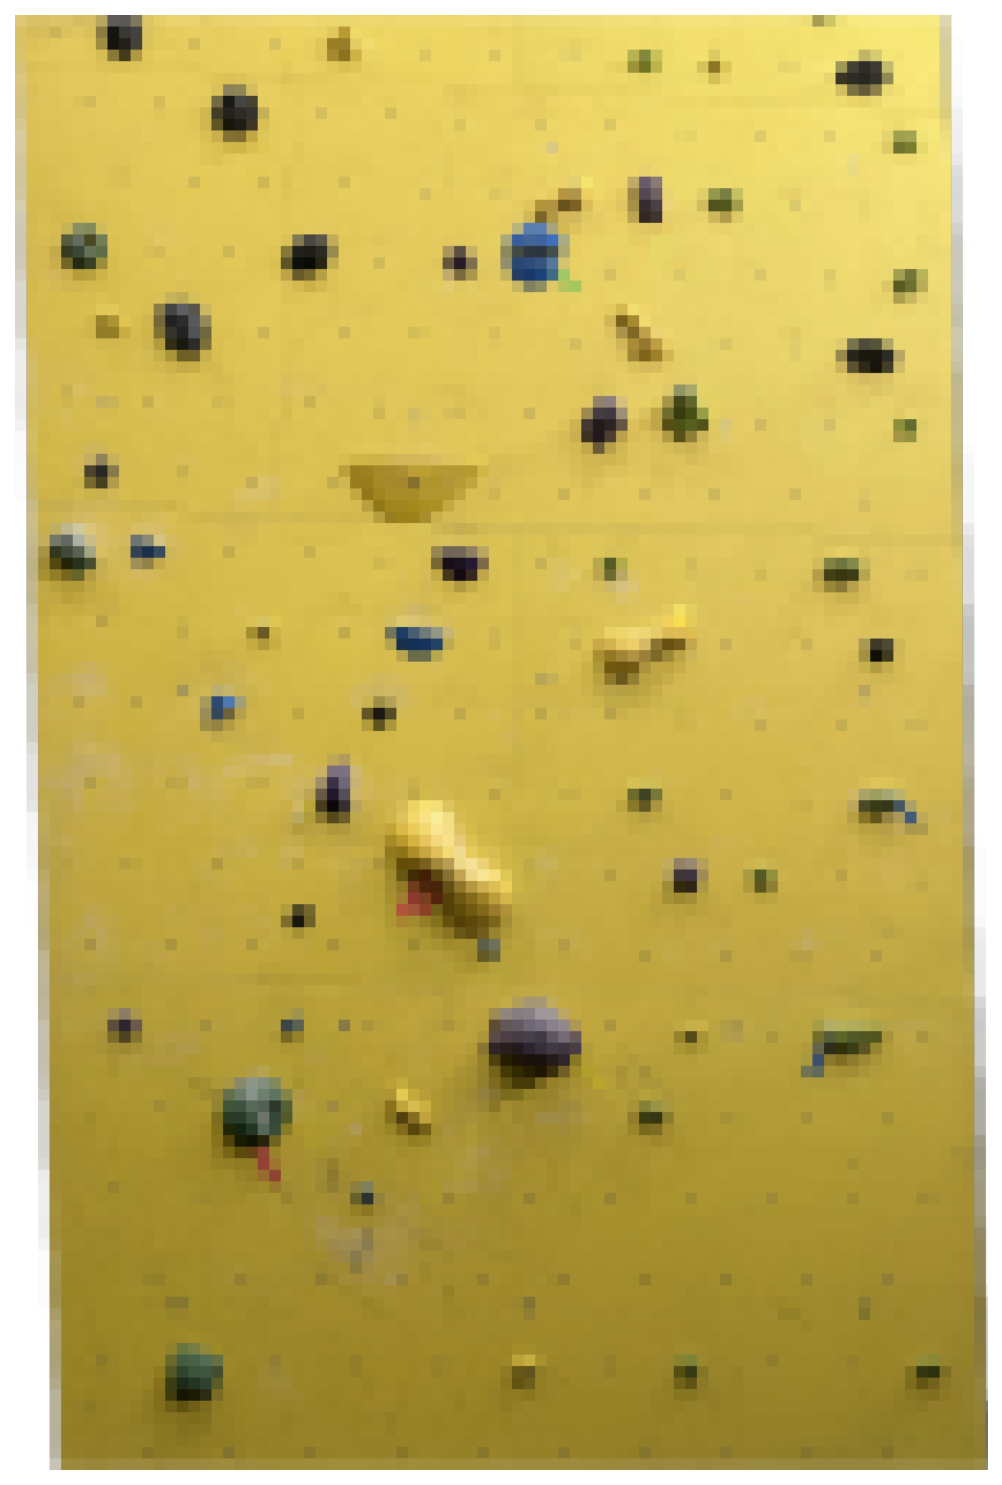

In [451]:
smoothed_image = smooth_image(f, kernel_size=32)
render_image(smoothed_image)

# Boost Contrast
(Not currently used)

In [452]:
import cv2

def boost_contrast(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Boost image contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization).
    
    Args:
        image: Input image array (height x width x channels)
        clip_limit: Threshold for contrast limiting (default: 2.0)
        tile_grid_size: Size of grid for histogram equalization (default: (8, 8))
    
    Returns:
        Image with enhanced contrast
    """
    # Convert to uint8 if needed (0-255 range)
    if image.max() <= 1.0:
        img_uint8 = (image * 255).astype(np.uint8)
    else:
        img_uint8 = image.astype(np.uint8)
    
    # Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # Convert to LAB color space for better results
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    
    # Apply CLAHE to L channel
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    
    # Convert back to RGB
    result = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    # Return in same format as input
    if image.max() <= 1.0:
        return result.astype(np.float64) / 255.0
    else:
        return result

In [453]:
# contrasted_image = boost_contrast(smoothed_image, clip_limit=2.0, tile_grid_size=(8, 8))
# render_image(contrasted_image)

# Round Colors

In [454]:
PALETTE = np.array([
    [0.0, 0.0, 0.0],      # Black
    [255, 255, 255],      # White
    [255, 0.0, 0.0],      # Red
    [45, 100, 47],      # Green
    [55, 84, 127],      # Blue
    [195, 170, 66],      # Yellow
    [0.0, 255, 255],      # Cyan
    # [255, 128, 0],      # Orange
    [63, 57, 68],      # Purple
    # [255, 192, 203],     # Pink
    # [166, 41, 41],   # Brown
    [128, 128, 128],      # Gray
])

# Normalize palette to [0, 1] range
PALETTE = PALETTE / 255.0

In [455]:
def round_colors(image, palette, kernel_size=8):
    """
    Round all blocks in the image to their nearest color in the palette.
    
    Args:
        image: Input image as numpy array (H, W, C)
        palette: Color palette as numpy array (N, 3) with values in [0, 1]
        kernel_size: Size of blocks to process (default: 8)
        
    Returns:
        Rounded image with colors from the palette
    """
    h, w, c = image.shape
    result = image.copy()
    
    # Process image in blocks
    for i in range(0, h, kernel_size):
        for j in range(0, w, kernel_size):
            # Get block bounds
            block_h = min(kernel_size, h - i)
            block_w = min(kernel_size, w - j)
            block = image[i:i+block_h, j:j+block_w]
            
            # Calculate average color of the block (only RGB channels)
            avg_color = np.mean(block, axis=(0, 1))[:3]
            
            # Find nearest color in palette
            distances = np.linalg.norm(palette - avg_color, axis=1)
            nearest_idx = np.argmin(distances)
            nearest_color = palette[nearest_idx]
            
            # Replace block with nearest color (only RGB channels, preserve alpha if present)
            result[i:i+block_h, j:j+block_w, :3] = nearest_color
    
    return result


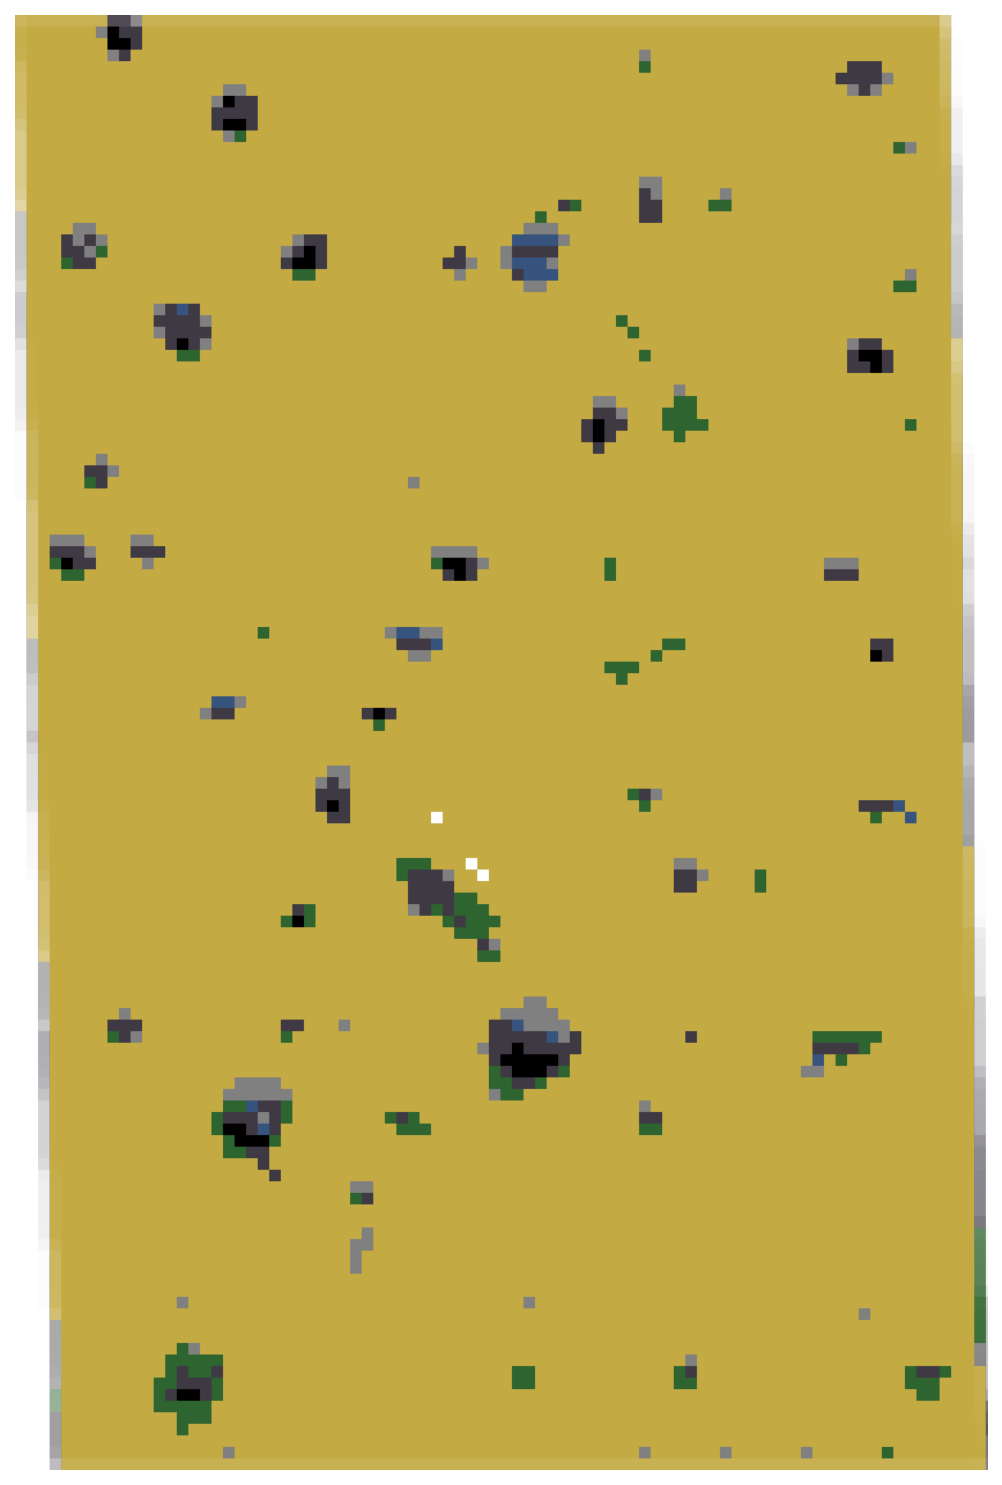

In [456]:
rounded_image = round_colors(smoothed_image, palette=PALETTE, kernel_size=32)
render_image(rounded_image)

# Strip Background Color
Thought: how effective is this when lighting changes?

In [457]:
def strip_background(image, kernel_size=64, tolerance=0.1):
    """
    Remove background color by finding the most common color in the image
    and making blocks close to that color transparent.
    
    Args:
        image: Input image array (height x width x channels)
        kernel_size: Size of each square section to analyze (default: 64)
        tolerance: How close a block needs to be to the background color (0-1, default: 0.1)
                  Lower values = stricter matching, higher values = more permissive
    
    Returns:
        Image with RGBA channels where background blocks are transparent
    """
    height, width = image.shape[:2]
    
    # Ensure image has alpha channel
    if image.shape[2] == 3:
        # Add alpha channel (fully opaque)
        result = np.dstack([image, np.ones((height, width))])
    else:
        result = image.copy()
    
    # Collect all block average colors
    block_colors = []
    for i in range(0, height, kernel_size):
        for j in range(0, width, kernel_size):
            i_end = min(i + kernel_size, height)
            j_end = min(j + kernel_size, width)
            section = image[i:i_end, j:j_end]
            avg_color = section.mean(axis=(0, 1))
            block_colors.append(avg_color[:3])  # Only RGB channels
    
    # Find the most common color (mode of block colors)
    block_colors = np.array(block_colors)
    # Use k-means or simple rounding to find most common
    # Round to reduce color space and find mode
    rounded_colors = np.round(block_colors * 10) / 10
    unique_colors, counts = np.unique(rounded_colors, axis=0, return_counts=True)
    background_color = unique_colors[np.argmax(counts)]
    
    # Make blocks similar to background color transparent
    for i in range(0, height, kernel_size):
        for j in range(0, width, kernel_size):
            i_end = min(i + kernel_size, height)
            j_end = min(j + kernel_size, width)
            section = image[i:i_end, j:j_end]
            avg_color = section.mean(axis=(0, 1))[:3]
            
            # Calculate color distance (Euclidean distance in RGB space)
            color_distance = np.linalg.norm(avg_color - background_color)
            
            # If close enough to background color, make transparent
            if color_distance < tolerance:
                result[i:i_end, j:j_end, 3] = 0  # Set alpha to 0 (transparent)
    
    return result

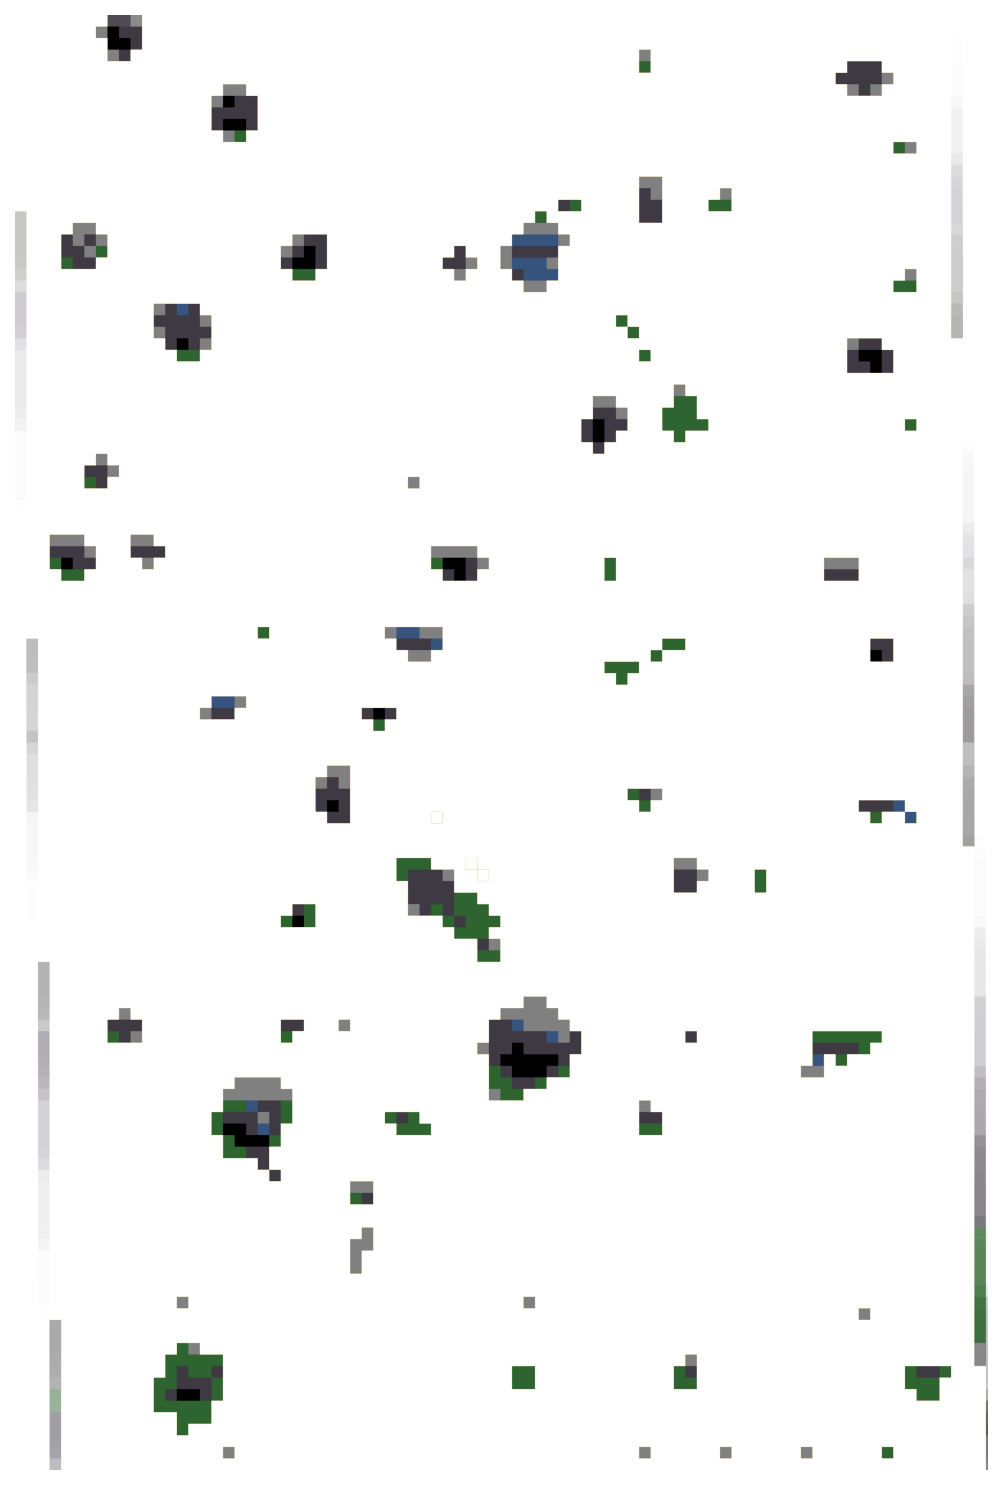

In [458]:
stripped_image = strip_background(rounded_image, kernel_size=32, tolerance=0.38)
render_image(stripped_image)

# Round Islands into Colored Squares

In [459]:
def round_islands_to_squares(image, kernel_size=32):
    """
    Find contiguous islands of colored pixels and convert them into rectangular blocks
    filled with the most common color of that island.
    
    Args:
        image: Input image array (height x width x channels)
        kernel_size: Size of blocks to process (default: 32)
        white_threshold: Threshold above which a color is considered white (default: 0.9)
    
    Returns:
        Image with islands converted to rectangles
    """
    height, width = image.shape[:2]
    result = image.copy()
    visited = np.zeros((height // kernel_size, width // kernel_size), dtype=bool)
    
    def is_transparent(color):
        """Check if a color is background (transparent)"""
        return (color.shape[0] == 4 and color[3] < 0.1)
    
    def get_block_color(i, j):
        """Get average color of a block"""
        i_end = min(i + kernel_size, height)
        j_end = min(j + kernel_size, width)
        section = image[i:i_end, j:j_end]
        return section.mean(axis=(0, 1))
    
    def flood_fill(start_row, start_col):
        """Find all connected blocks of the same color using BFS"""
        start_color = get_block_color(start_row * kernel_size, start_col * kernel_size)
        
        if is_transparent(start_color):
            return None
        
        queue = [(start_row, start_col)]
        visited[start_row, start_col] = True
        island_blocks = [(start_row, start_col)]
        colors = [start_color]
        
        while queue:
            row, col = queue.pop(0)
            
            # Check 4-connected neighbors
            for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                new_row, new_col = row + dr, col + dc
                
                # Check bounds
                if (0 <= new_row < visited.shape[0] and 
                    0 <= new_col < visited.shape[1] and 
                    not visited[new_row, new_col]):
                    
                    neighbor_color = get_block_color(new_row * kernel_size, new_col * kernel_size)
                    
                    # Check if color is not transparent
                    if (not is_transparent(neighbor_color)):
                        visited[new_row, new_col] = True
                        queue.append((new_row, new_col))
                        island_blocks.append((new_row, new_col))
                        colors.append(neighbor_color)
        
        return island_blocks, colors
    
    # Process each block
    for block_row in range(visited.shape[0]):
        for block_col in range(visited.shape[1]):
            if not visited[block_row, block_col]:
                island_data = flood_fill(block_row, block_col)
                
                if island_data is not None:
                    island_blocks, colors = island_data
                    
                    # Find bounding box
                    rows = [block[0] for block in island_blocks]
                    cols = [block[1] for block in island_blocks]
                    min_row, max_row = min(rows), max(rows)
                    min_col, max_col = min(cols), max(cols)
                    
                    # Calculate most common color (average of all colors in island)
                    avg_color = np.mean(colors, axis=0)
                    
                    # Fill the entire bounding rectangle with the average color
                    for row in range(min_row, max_row + 1):
                        for col in range(min_col, max_col + 1):
                            i = row * kernel_size
                            j = col * kernel_size
                            i_end = min(i + kernel_size, height)
                            j_end = min(j + kernel_size, width)
                            result[i:i_end, j:j_end] = avg_color
    
    return result


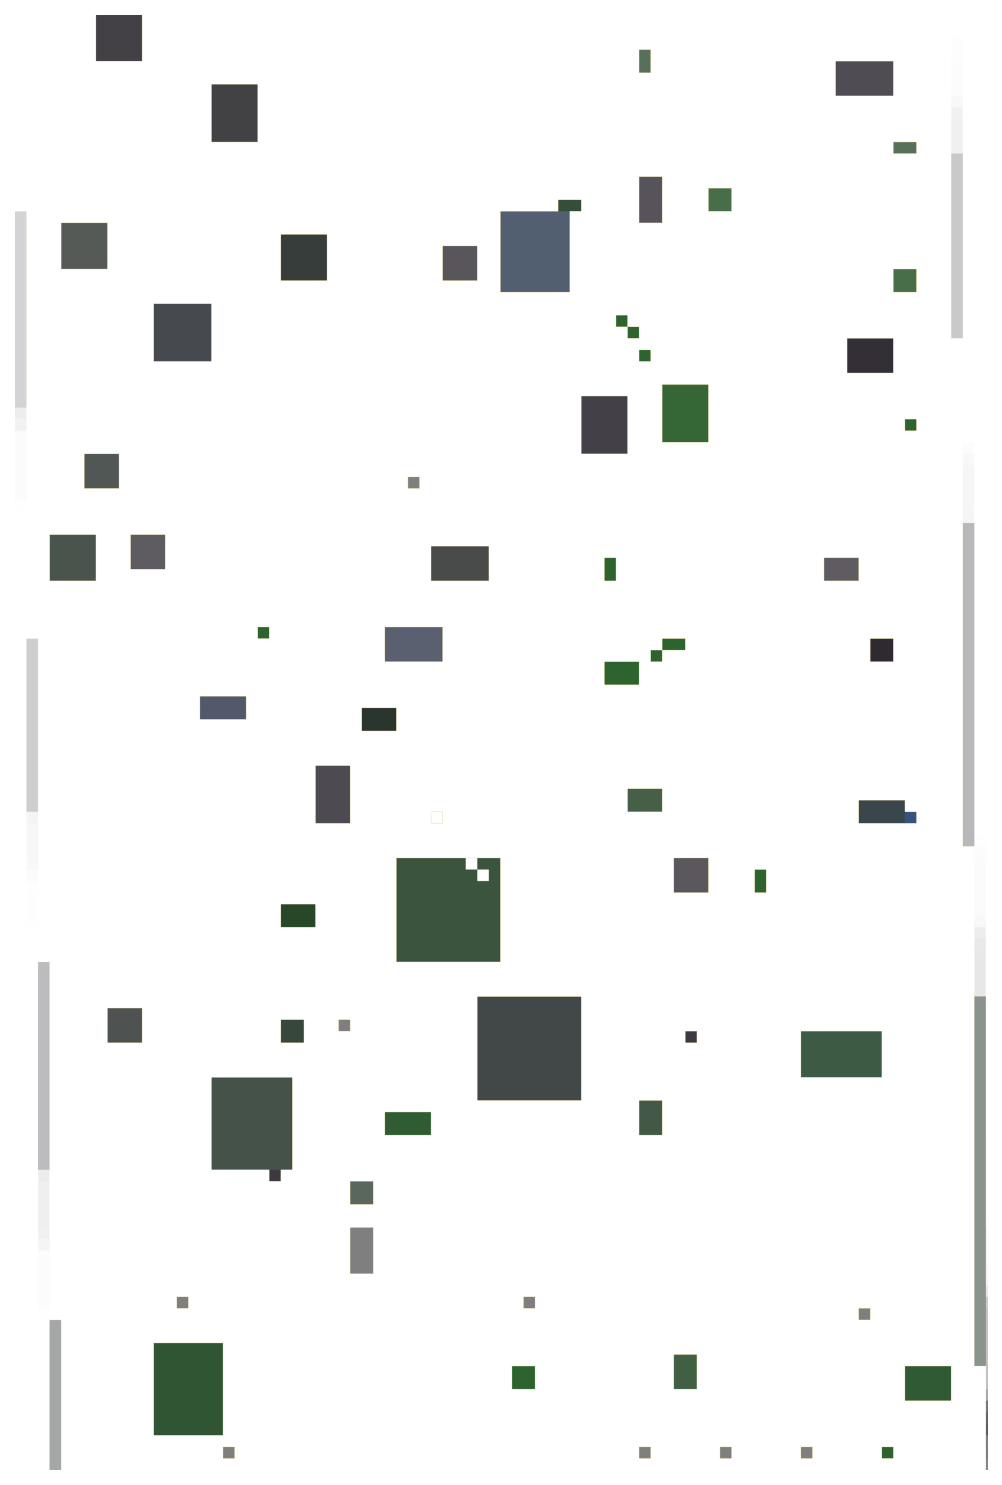

In [460]:
islands_image = round_islands_to_squares(stripped_image, kernel_size=32)
render_image(islands_image)

# Subdivide Image into Vertical Columns
For visuals only: do not use this image for hashing

# Working Notes
- use **vertical** sections of the wall to compute the hash? This seems to make more sense for climbing walls, and will make hashing more consistent when we correct image orientation later
- We can use similar sections of the wall that we've seen before to compute where we are in the gym (future)